In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle

def print_loss(loss):
    return plt.plot([float(l['loss']) for l in loss])

model_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
              'MEAN_MOTION', 'epoch_jd', 'epoch_fr',
              #'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 
             ]
perc = 0.05           # Amount of the training data to use (percent of norads)
force_update = False  # If false, we will load the pre-processed data.  Otherwise, do the pre-processing.

In [2]:
%%time
import clean_data

def clean_all(train_df, test_df):
    for df in [train_df, test_df]:
        df = clean_data.add_epoch_data(df)
        df = clean_data.normalize_all_columns(df)
    return train_df, test_df

def load_all():
    train_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train.pkl' ) # Time: 25.7s
    test_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/test.pkl' ) # Time: 5
    return train_df, test_df

def build_df(perc):
    train_df, test_df = load_all()

    # Percent of NORADs to use during training...
    norad_count = int(len(train_df.NORAD_CAT_ID.unique()) * perc)
    train_df = train_df[train_df.NORAD_CAT_ID.isin(train_df.NORAD_CAT_ID.unique()[:norad_count])].reset_index(drop=True)

    # Limit to 1990 and after...
    train_df = train_df.loc[train_df.EPOCH >= '1990-01-01'].reset_index(drop=True)
    test_df = test_df.loc[test_df.EPOCH >= '1990-01-01'].reset_index(drop=True)

    # Drop large mean motions
    train_df = train_df[abs(train_df.MEAN_MOTION) < 20].reset_index(drop=True)  # drops 1
    test_df = test_df[abs(test_df.MEAN_MOTION) < 20].reset_index(drop=True) # drops 2 (on ??%)

    # Drop large bstars
    train_df = train_df[abs(train_df.BSTAR) < 10].reset_index(drop=True)  # drops 779 / 9745803
    test_df = test_df[abs(test_df.BSTAR) < 10].reset_index(drop=True) # drops 187 / 8309251 (on 5%)
    
    # Clean data
    train_df,test_df = clean_all(train_df, test_df)

    # Save
    train_df.to_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train_'+ str(int(perc*100)) + 'p.pkl')
    test_df.to_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/test_'+ str(int(perc*100)) + 'p.pkl')
    
    return train_df, test_df

if not force_update:
    try:
        train_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train_'+ str(int(perc*100)) + 'p.pkl')
        test_df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/test_'+ str(int(perc*100)) + 'p.pkl')
    except:
        train_df, test_df = build_df(perc)
else:
    train_df, test_df = build_df(perc)
    
train_model_df = train_df[model_cols]
test_model_df = test_df[model_cols]

Wall time: 6.03 s


|Data Change History | Time |
|:-|-|
|10% of all TLEs|8s|
|20% of all TLEs|14s|
|10% of all TLEs, only after 1990|11s|

In [3]:
%%time

def build_idx_pairs(perc):
    train_idx_map = clean_data.create_index_map(train_df)
    test_idx_map = clean_data.create_index_map(test_df)
    
    with open(os.environ['GP_HIST_PATH'] + '/raw_compiled/train_idx_'+ str(int(perc*100)) + 'p.pkl', 'wb') as hdl:
        pickle.dump(train_idx_map, hdl)
    with open(os.environ['GP_HIST_PATH'] + '/raw_compiled/test_idx_'+ str(int(perc*100)) + 'p.pkl', 'wb') as hdl:
        pickle.dump(test_idx_map, hdl)
        
    return train_idx_map, test_idx_map

if not force_update:
    try:
        with open(os.environ['GP_HIST_PATH'] + '/raw_compiled/train_idx_'+ str(int(perc*100)) + 'p.pkl', 'rb') as hdl:
            train_idx_map = pickle.load(hdl)
        with open(os.environ['GP_HIST_PATH'] + '/raw_compiled/test_idx_'+ str(int(perc*100)) + 'p.pkl', 'rb') as hdl:
            test_idx_map = pickle.load(hdl)
    except:
        train_idx_map,test_idx_map = build_idx_pairs(perc)
else:
    train_idx_map,test_idx_map = build_idx_pairs(perc)

X_test,y_test = clean_data.build_xy(test_model_df,test_idx_map)  # create input/label pair

Wall time: 3.78 s


|Data Change History | Time |
|:-|-|
|10% of all TLEs|5min|
|20% of all TLEs|10min|
|10% of all TLEs, only after 1990|3min|

In [5]:
import train

model = train.create_model(model_cols=model_cols,
                           layer1=300, relu1=True, #drop1=0.5,
                           layer2=100, relu2=True, #drop2=0.5,
                           layer3=10, relu3=True, #drop3=0.5,
                           layer4=10, relu4=True, #drop4=0.5,
                           layer5=10, relu5=True, #drop5=0.5,
                          )
model

NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=11, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=10, out_features=10, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=10, out_features=10, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=10, out_features=7, bias=True)
    (16): ReLU()
  )
)

In [6]:
%%time
device='cpu'

# Simple model with one hidden layer
# trained_model, loss_output = train.train_model(train_model_df, train_idx_map, batchSize=200,
#                           print_itr=10000, numEpochs=10, model_cols=model_cols,
#                           learningRate=0.01, device=device, num_workers=10,
#                           loss='L2', hiddenSize=10)

trained_model, loss_output = train.train_model(train_model_df, train_idx_map, batchSize=200,
                                               print_itr=40000, numEpochs=10, model_cols=model_cols,
                                               learningRate=0.01, device=device, num_workers=10,
                                               loss='L2', model=model)

y_pred = train.predict(trained_model, X_test, device=device) # get predictions for each train
y_pred_df = pd.DataFrame(y_pred, columns=test_model_df.columns[:-2])  # put results into a dataframe

>>> Loading dataset
>>> Beginning training!
Epoch [1/10], Batch [40000/41546], Loss: 0.19750764966011047, Time: 127s
Epoch [2/10], Batch [40000/41546], Loss: 0.15276175737380981, Time: 155s
Epoch [3/10], Batch [40000/41546], Loss: 0.13451817631721497, Time: 167s
Epoch [4/10], Batch [40000/41546], Loss: 0.14964261651039124, Time: 168s
Epoch [5/10], Batch [40000/41546], Loss: 0.12074091285467148, Time: 169s
Epoch [6/10], Batch [40000/41546], Loss: 0.3468679189682007, Time: 168s
Epoch [7/10], Batch [40000/41546], Loss: 0.24493761360645294, Time: 168s
Epoch [8/10], Batch [40000/41546], Loss: 0.12844689190387726, Time: 168s
Epoch [9/10], Batch [40000/41546], Loss: 0.1496429145336151, Time: 170s
Epoch [10/10], Batch [40000/41546], Loss: 0.15206021070480347, Time: 170s
Final loss: 0.11316560208797455
Wall time: 27min 54s


    Test set MAE (L1) loss: 0.24036678088627433
    Test set MSE (L2) loss: 0.2580651566031818


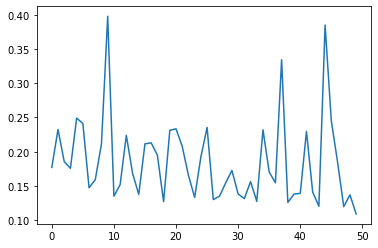

In [7]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_pred_df)}')

print_loss(loss_output)

# Loss Tracking

|Test L1 Loss | Test L2 Loss | NN Change History | Time |
|:-|:-|:-|-|
|0.1234|21.7614|norads=10%, epochs=10, batchSize=200,<br> learn=0.0001, device=cpu, loss=l2,<br> num_workers=5, hidden=300|28min 39s|
|0.1235|34.4868|num_workers=20|28min 54s|
|0.1222|30.8207|norads=20%, num_workers=5|53min 47s|
|0.1219|26.2414|norads=5%, tles-after-1990|12min 46s|
|0.1217|0.1226|remove-high-mean-motion|13min 22s|
|0.1211|0.1235|norads=10%|27min 35s|
|0.1221|0.1232|hidden=10|22min 33s|
|0.1330|0.1380|updated mean_motion standardization|24min 16s|
|0.1329|0.1380|norads=5%|12min 36s|
|0.1322|0.1385|run-local|6min 18s|
|0.1302|0.1373|num-workers=10|4min 44s|
|0.1302|0.1373|num-workers=10|4min 44s|
|0.1304|0.0631|remove-high-bstar|4min 37s|
|0.1289|0.0601|hidden=300|8min 31s|
|0.1423|0.0652|hidden1=100, hidden2=100, drop=50%,<br>batchSize=2000, epoch=5|2min 51s|
|0.1397|0.0614|hidden1=300, drop=50%,<br>hidden2=100, drop=50%,<br>hidden3=10, drop=50%,<br>hidden4=10, drop=50%,<br>hidden5=10, drop=50%,<br>batchSize=2000, epoch=10, learn=0.01|6min 12s|

In [20]:
def test(one, **kwargs):
    print (f'Got {one} and {kwargs.items()}')

test('3', hello='3')

Got 3 and dict_items([('hello', '3')])


In [21]:
import torch
import torch.nn as nn

my_nn = [nn.Linear(in_features=1, out_features=3), 
    nn.ReLU(), 
    nn.Linear(in_features=3, out_features=1)]

nn.Sequential(*my_nn)

Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

In [33]:
clean_data.normalize_all_columns(y_test.head().copy(), reverse=True)

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000070,99.0273,91.4724,0.006882,213.8838,145.7902,13.878280
1,0.000176,99.3609,338.5575,0.006719,212.1980,147.5052,13.897694
2,0.000025,99.1325,235.7922,0.006615,284.4164,230.4278,13.901623
3,0.000079,98.8742,295.6128,0.006941,113.3722,247.4756,13.876448
4,0.000055,99.5139,341.9707,0.006715,265.5062,93.8418,13.895170


In [34]:
clean_data.normalize_all_columns(y_pred_df.head().copy(), reverse=True)  # reverse the normalization

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000128,99.367409,177.987976,0.007505,176.273544,182.977768,13.806324
1,0.000277,98.968285,174.250443,0.005652,178.784195,180.315643,13.984055
2,-0.000128,99.206566,178.081787,0.007398,178.893494,179.152985,13.855957
3,0.000518,99.812462,176.744812,0.008204,177.181229,179.876694,13.731467
4,0.000008,98.896675,180.470947,0.005795,176.439316,181.367020,14.035645


In [35]:
y_diff = y_test.to_numpy() - y_pred_df.to_numpy()

In [36]:
y_se = y_diff**2

In [37]:
np.mean(y_se)

0.13768172951482716

In [38]:
np.mean(y_se, axis=0)

array([5.82604576e-01, 2.52606722e-05, 8.38049454e-02, 5.14893337e-04,
       8.33889401e-02, 8.61190085e-02, 1.27314483e-01])

In [39]:
np.mean(y_se, axis=1).max()

571322.2075536742

In [40]:
y_se[:,5].max()

52.57713371478427

In [41]:
np.argmax(y_se[:,5])

6344333

In [42]:
y_pred_df.sort_values(by='MEAN_MOTION', ascending=False)

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
9387407,0.694890,0.107023,0.506011,0.346137,0.297312,0.446885,2.611735
827215,3.230368,-0.911655,1.439745,2.279228,0.428236,0.242968,2.091965
5637016,-0.022609,0.456871,0.520049,0.168708,0.454958,0.549145,1.966734
2516423,-0.022264,0.386138,0.510685,0.170994,0.463729,0.518819,1.946972
1025982,-0.002358,0.538693,0.498795,0.069045,0.469660,0.534245,1.856623
...,...,...,...,...,...,...,...
9011387,3.652119,0.622109,4.245997,-0.106912,-3.331690,1.684346,-25.888645
6668333,4.563804,0.570290,5.306349,-0.110917,-4.532779,2.056255,-33.479591
6568739,5.652286,0.713150,6.281126,-0.158497,-5.720661,2.357029,-41.915901
9041996,5.911437,0.463917,6.648518,-0.076233,-5.954375,2.410160,-43.209641


In [45]:
y_test.iloc[6344333]

BSTAR                 0.002000
INCLINATION           0.363013
RA_OF_ASC_NODE        0.907445
ECCENTRICITY          0.886939
ARG_OF_PERICENTER     0.140733
MEAN_ANOMALY          0.980253
MEAN_MOTION         -11.742837
Name: 6344333, dtype: float64

In [46]:
X_test.iloc[6344333]

BSTAR                2000.000000
INCLINATION             0.346807
RA_OF_ASC_NODE          0.377513
ECCENTRICITY            0.338590
ARG_OF_PERICENTER       0.317030
MEAN_ANOMALY            0.740220
MEAN_MOTION            -0.598147
epoch_jd                0.886982
epoch_fr                0.374051
epoch_jd_y              0.828464
epoch_fr_y              0.442037
Name: 6344333, dtype: float64

In [47]:
clean_data.normalize_all_columns(test_df.iloc[test_idx_map[6344333][0]].copy())

NORAD_CAT_ID                                                      9889
OBJECT_TYPE                                                     DEBRIS
OBJECT_NAME                                             COSMOS 862 DEB
TLE_LINE1            1 09889U 76105F   14149.37405109  .99999999  0...
TLE_LINE2            2 09889 062.4253 135.9048 0388172 114.1307 266...
MEAN_MOTION_DOT                                                    1.0
MEAN_MOTION_DDOT                                                   0.0
BSTAR                                                          40000.0
INCLINATION                                                   0.001927
RA_OF_ASC_NODE                                                0.001049
ECCENTRICITY                                                  0.696987
ARG_OF_PERICENTER                                             0.000881
MEAN_ANOMALY                                                  0.002056
MEAN_MOTION                                                 -14.348147
EPOCH 

In [19]:
test_df.MEAN_MOTION.describe()

count    9.745803e+06
mean     6.433186e-03
std      1.208737e+00
min     -1.276513e+01
25%     -2.767648e-01
50%      2.735473e-01
75%      6.172884e-01
max      2.828760e+00
Name: MEAN_MOTION, dtype: float64

In [20]:
train_df.MEAN_MOTION.describe()

count    8.309251e+06
mean    -6.641995e-02
std      1.000701e+00
min     -1.275089e+01
25%     -4.354280e-01
50%      1.358416e-01
75%      5.215083e-01
max      2.800927e+00
Name: MEAN_MOTION, dtype: float64

In [21]:
len(test_df)

9745803

In [21]:
test_df.MEAN_MOTION.sort_values()

788213    -12.765129
6092401   -12.747369
6389269   -12.747307
786326    -12.747295
4733230   -12.747279
             ...    
983840      2.787466
3448121     2.792547
1608752     2.800919
4898083     2.801152
983842      2.828760
Name: MEAN_MOTION, Length: 9745803, dtype: float64

In [22]:
train_df.MEAN_MOTION.sort_values()

880177    -12.750892
1015425   -12.747301
930452    -12.747238
930453    -12.747235
987189    -11.814547
             ...    
6114164     2.680907
6313579     2.692586
6258520     2.736366
5326336     2.755610
5983771     2.800927
Name: MEAN_MOTION, Length: 8309251, dtype: float64

In [23]:
test_idx_map[9393426][0]

9125280